## Load and Preprocess PVEL-AD Data

In [1]:
import xml.etree.ElementTree as ET
import os
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np

## Load and recategorise defective images and labels

In [2]:
image_folder = 'Dataset/PVEL-AD/trainval/JPEGImages'
xml_folder = f'Dataset/PVEL-AD/trainval/Annotations'

### Read labels

In [3]:
# Read labels corresponding to each image and store in label_dict.
# Remove images with only printing_error, corner, fragment, scratch.
# crack and star_crack merged into crack.

label_dict = {}
for xml_filename in os.listdir(xml_folder):
    if xml_filename.endswith('.xml'):
        xml_filepath = os.path.join(xml_folder, xml_filename)
        root = ET.parse(xml_filepath).getroot()
        img_filename = root.find('filename').text
        labels = []
        for obj in root.iter('object'):
            label_text = obj.find('name').text
            if label_text not in ('printing_error', 'corner', 'fragment', 'scratch'):
                if label_text == 'star_crack':
                    label_text = 'crack'
                labels.append(label_text)
        
        if len(labels) > 0:
            label_dict[img_filename] = tuple(set(labels))

In [4]:
# Total samples

len(label_dict.keys())

4493

In [5]:
# Count images having more than one type of label

multilabel_count = [0 for i in range(13)]

for label in label_dict.values():
    multilabel_count[len(label)] += 1

print('No. of labels      Number of images')
for i, img_count in enumerate(multilabel_count):
    print(f'{i}\t\t\t{img_count}')

No. of labels      Number of images
0			0
1			3898
2			566
3			29
4			0
5			0
6			0
7			0
8			0
9			0
10			0
11			0
12			0


In [6]:
# Count of all unique label combinations

value_counts = Counter(label_dict.values())
for label, count in value_counts.items():
    print(f'{label}: {count}')

('crack',): 575
('short_circuit',): 492
('black_core',): 983
('finger',): 965
('thick_line',): 583
('crack', 'finger'): 378
('thick_line', 'crack', 'finger'): 25
('thick_line', 'finger'): 119
('horizontal_dislocation',): 266
('thick_line', 'crack'): 45
('black_core', 'finger'): 15
('crack', 'black_core'): 7
('crack', 'black_core', 'finger'): 3
('vertical_dislocation',): 34
('thick_line', 'black_core'): 2
('thick_line', 'black_core', 'finger'): 1


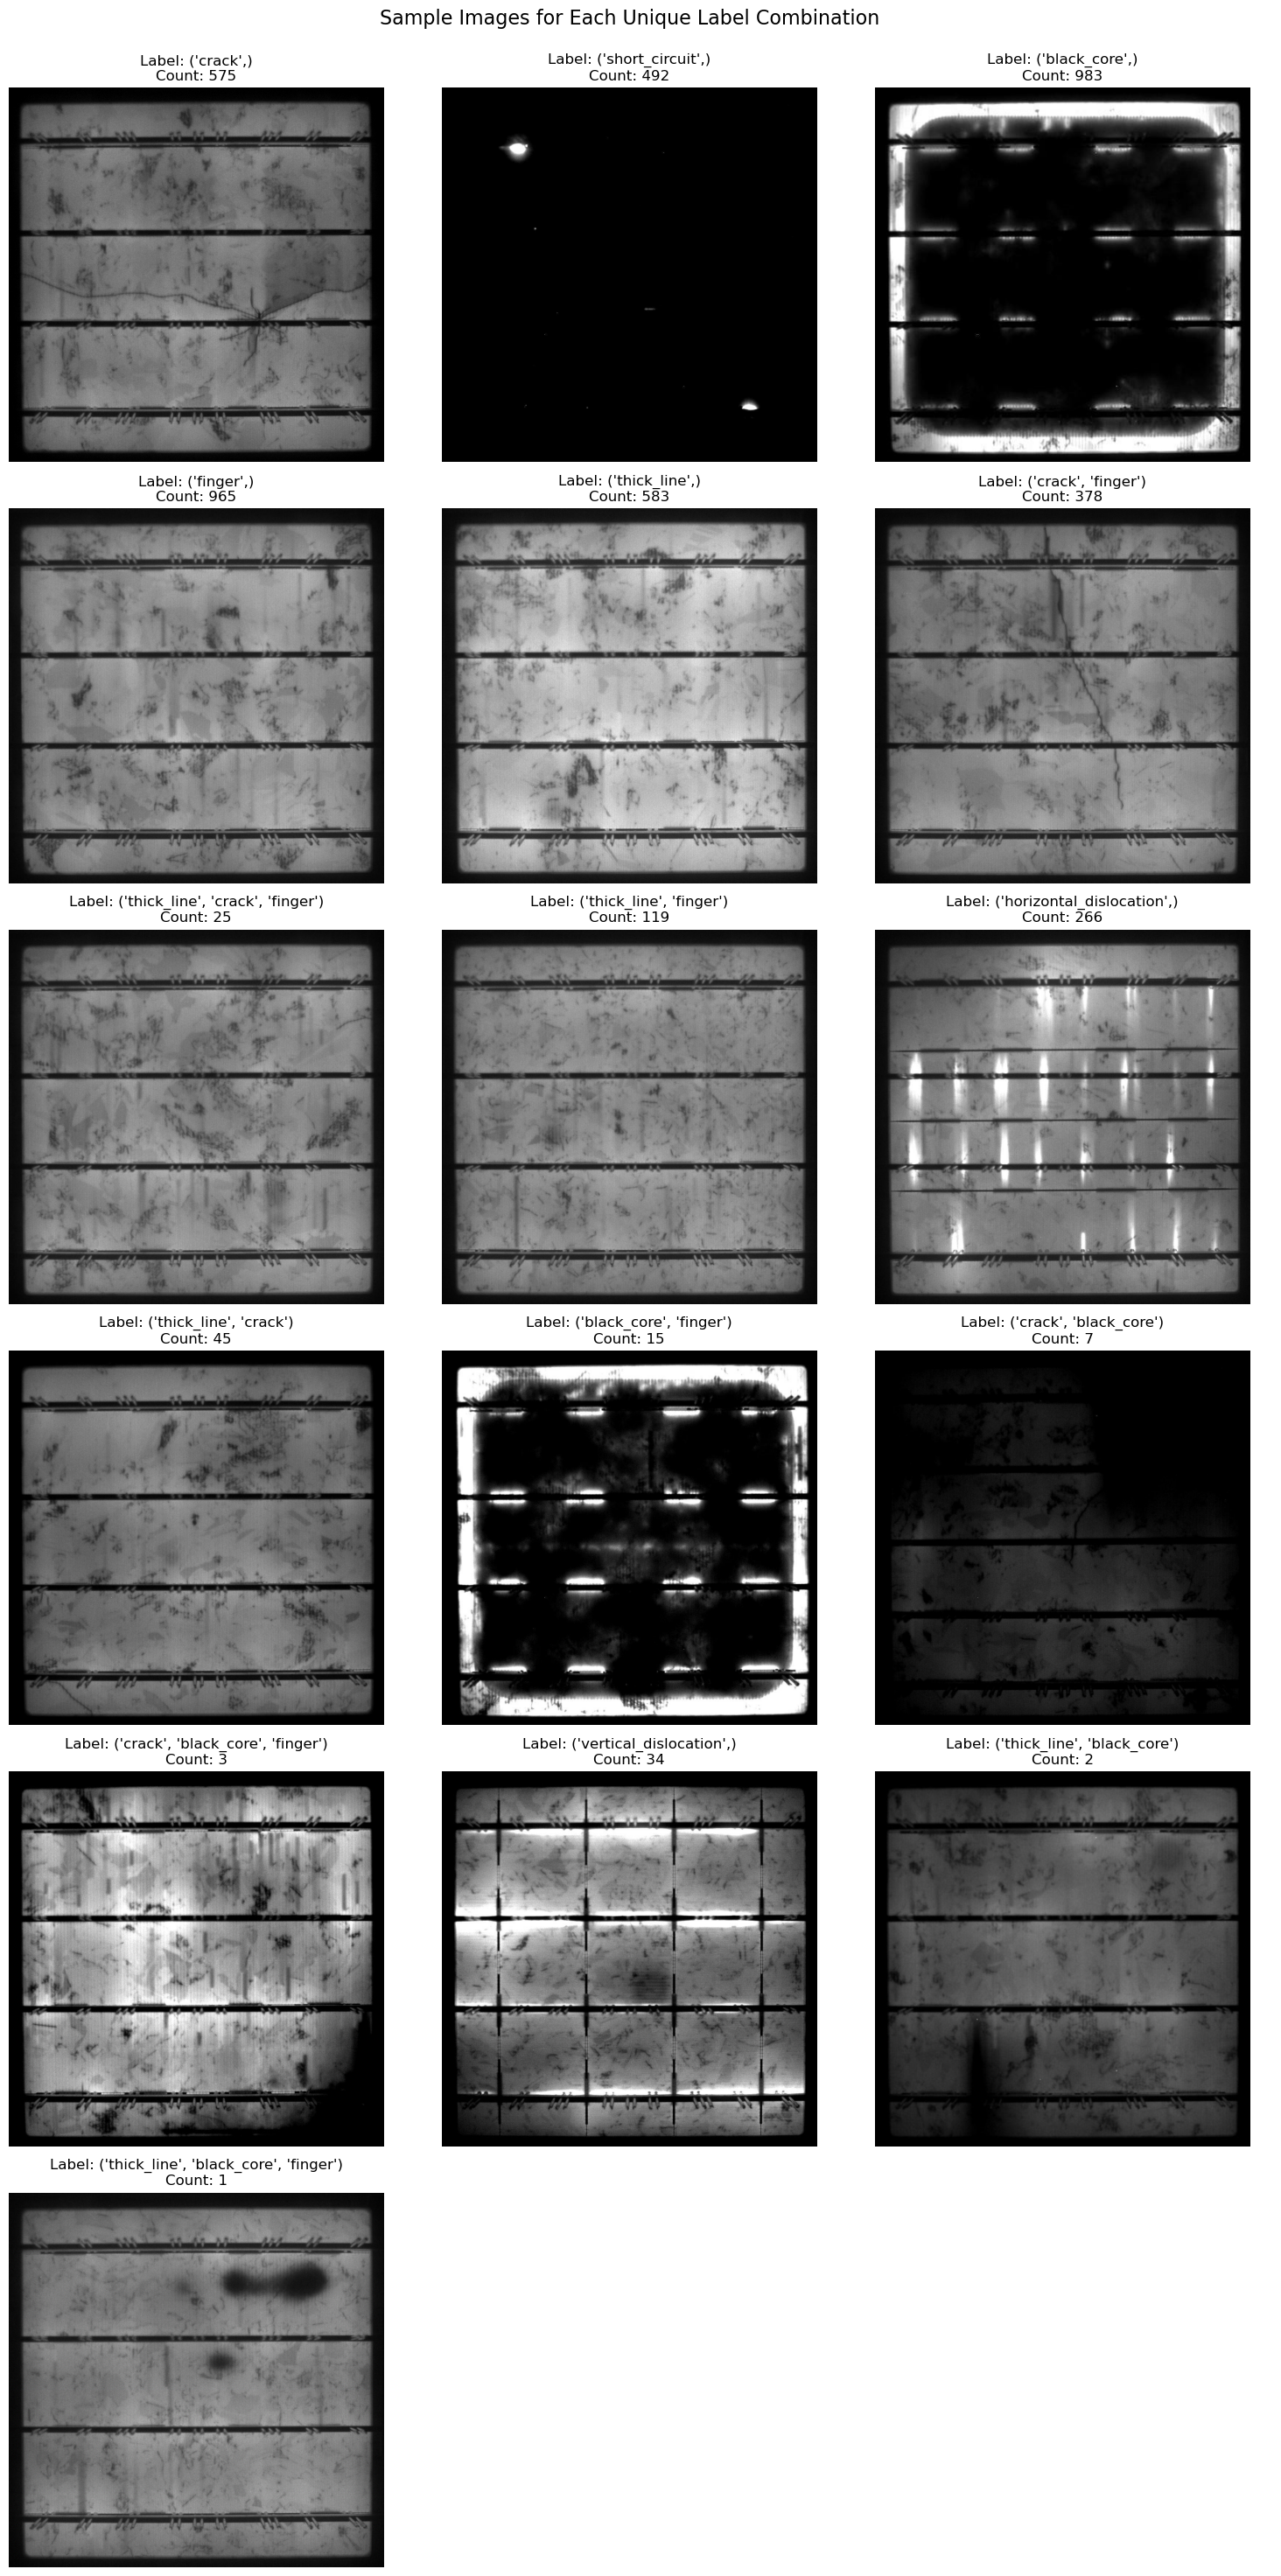

In [7]:
# Sample images for each unique label combination

image_folder = "Dataset/PVEL-AD/trainval/JPEGImages"

# Assuming `label_dict` is your dictionary with image names as keys and label lists as values
value_counts = Counter(map(lambda x: tuple(x), label_dict.values()))

# Set the figure size based on number of unique labels
num_labels = len(value_counts)
cols = 3  # Number of columns in the grid
rows = (num_labels + cols - 1) // cols  # Calculate rows needed

# Create a figure with the appropriate number of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust size as needed
fig.suptitle("Sample Images for Each Unique Label Combination", fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

# Display each unique label's sample image
for idx, (label, count) in enumerate(value_counts.items()):
    # Find an image with the current label combination
    sample_image = next(img for img, lbl in label_dict.items() if tuple(lbl) == label)
    img_path = os.path.join(image_folder, sample_image)
    
    # Read and display the image
    img = mpimg.imread(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(f"Label: {label}\nCount: {count}", fontsize=12)
    axes[idx].axis('off')

# Hide any unused subplots
for ax in axes[num_labels:]:
    ax.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Add some space for the main title
plt.show()

In [8]:
# map multi-label combinations to single most prominent label

prominent_defect_map = {
    ('crack', 'finger'): 'crack',
    ('crack', 'finger', 'thick_line'): 'crack',
    ('finger', 'thick_line'): 'crack',
    ('crack', 'thick_line'): 'crack',
    ('black_core', 'finger'): 'black_core',
    ('crack', 'black_core'): 'black_core',
    ('crack', 'black_core', 'finger'): 'black_core',
    ('black_core', 'thick_line'): 'black_core',
    ('black_core', 'finger', 'thick_line'): 'black_core'
}

for key, value in label_dict.items():
    if value in prominent_defect_map:
        label_dict[key] = prominent_defect_map[value]
    else:
        label_dict[key] = label_dict[key][0]

In [9]:
# put defects with low representation in single label

recategoristion_map = {
    'short_circuit': 'other',
    'thick_line': 'other',
    'horizontal_dislocation': 'other',
    'vertical_dislocation': 'other',
}

for key, value in label_dict.items():
    if value in recategoristion_map:
        label_dict[key] = recategoristion_map[value]

In [10]:
# Count of all unique label combinations

value_counts = Counter(label_dict.values())
for label, count in value_counts.items():
    print(f'{label}: {count}')

crack: 953
other: 1567
black_core: 1008
finger: 965


In [11]:
df = pd.DataFrame(label_dict.items(), columns=['img_filename', 'label'])
df

,img_filename,label
0,img001445.jpg,crack
1,img000983.jpg,crack
2,img023182.jpg,other
3,img003252.jpg,black_core
4,img003534.jpg,black_core
...,...,...
4488,img000024.jpg,finger
4489,img002633.jpg,crack
4490,img002155.jpg,other
4491,img021954.jpg,other


## Load nominal images and labels

In [12]:
nominal_image_folder = 'Dataset/PVEL-AD/othertypes/good'

In [13]:
nominal_image_filenames = []
for filename in os.listdir(nominal_image_folder):
    if filename.endswith('.jpg'):
        nominal_image_filenames.append(filename)

In [14]:
# total nominal images

len(nominal_image_filenames)

11353

In [15]:
df_nominal = pd.DataFrame({
    'img_filename' : nominal_image_filenames[:4493],
    'label' : ['normal'] * 4493
})

df_nominal

,img_filename,label
0,img035079.jpg,normal
1,img032716.jpg,normal
2,img033408.jpg,normal
3,img034367.jpg,normal
4,img030101.jpg,normal
...,...,...
4488,img031859.jpg,normal
4489,img031681.jpg,normal
4490,img027785.jpg,normal
4491,img029970.jpg,normal


In [16]:
df_complete = pd.concat([df, df_nominal])
df_complete

,img_filename,label
0,img001445.jpg,crack
1,img000983.jpg,crack
2,img023182.jpg,other
3,img003252.jpg,black_core
4,img003534.jpg,black_core
...,...,...
4488,img031859.jpg,normal
4489,img031681.jpg,normal
4490,img027785.jpg,normal
4491,img029970.jpg,normal


In [17]:
df_complete.reset_index(inplace=True)
df_complete.drop(columns=['index'], inplace=True)
df_complete

,img_filename,label
0,img001445.jpg,crack
1,img000983.jpg,crack
2,img023182.jpg,other
3,img003252.jpg,black_core
4,img003534.jpg,black_core
...,...,...
8981,img031859.jpg,normal
8982,img031681.jpg,normal
8983,img027785.jpg,normal
8984,img029970.jpg,normal


In [18]:
# Apply one-hot encoding to label column

ohe = OneHotEncoder()
label_ohe = ohe.fit_transform(np.reshape(np.array(df_complete['label']), (-1,1)))

df_label_ohe = pd.DataFrame(label_ohe.toarray(), 
                            columns=pd.Series(ohe.get_feature_names_out()).str.split('_', 1).str[1], 
                            dtype=int)

df1 = pd.concat([df_complete, df_label_ohe], axis=1)
df1.drop(columns=['label'], inplace=True)
df1

,img_filename,black_core,crack,finger,normal,other
0,img001445.jpg,0,1,0,0,0
1,img000983.jpg,0,1,0,0,0
2,img023182.jpg,0,0,0,0,1
3,img003252.jpg,1,0,0,0,0
4,img003534.jpg,1,0,0,0,0
...,...,...,...,...,...,...
8981,img031859.jpg,0,0,0,1,0
8982,img031681.jpg,0,0,0,1,0
8983,img027785.jpg,0,0,0,1,0
8984,img029970.jpg,0,0,0,1,0


<br>

### Save the new dataset

In [23]:
from PIL import Image

In [22]:
new_img_folder_path = 'Dataset/Modified_PVELAD_Data/images'
image_folder_normal = "Dataset/PVEL-AD/othertypes/good"
image_folder_defective = 'Dataset/PVEL-AD/trainval/JPEGImages'

In [28]:
# Save chosen images in a new directory
for i, row in df1.iterrows():
    img_filename = row['img_filename']
    if row['normal'] == 1:
        src_img_path = os.path.join(image_folder_normal, img_filename)
    else:
        src_img_path = os.path.join(image_folder_defective, img_filename)

    dest_path = os.path.join(new_img_folder_path, img_filename)

    # Load and preprocess the image using PIL
    img = Image.open(src_img_path).convert('RGB')  # Ensure the image has 3 channels (RGB)
    img = img.resize((1024, 1024))  # Resize the image to target_size
    img.save(dest_path)

In [29]:
# Save one-hot encoded labels csv

df1.to_csv('Dataset/Modified_PVELAD_Data/labels.csv', index=False)